# Demo RNA de Hopfield para procesar imágenes e identificar símbolos
Funciones adaptadas de https://github.com/yosukekatada/Hopfield_network/blob/master/hopfield.py

In [ ]:
#@title Librerías a usar

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image
from PIL import ImageDraw
import random
import copy

import ipywidgets as widgets
from ipywidgets import Box, Layout

print("Librerías cargadas")

Librerías cargadas


##Imágenes:

In [ ]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/demosColab/demoIA/imagenes' #@param {type:"string"}


Mounted at /content/gdrive


Tamaño Imagen:  (150, 150, 1)

 CIRCULO


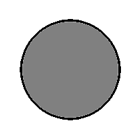


 CUADRADO


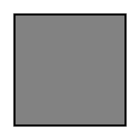


 TRIANGULO


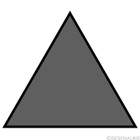



> Imágenes cargadas para Entrenamiento:  3


In [ ]:
#@title Cargar imagen para cada clase

imagen_ancho =  150 #@param {type:"integer"}
imagen_alto =  150 #@param {type:"integer"}
imagen_ajustar_tamaño_x = 5 #@param {type:"integer"}
imagen_ajustar_tamaño_y =  5#@param {type:"integer"}
threshold_pixel_blanco = 120 #@param {type:"integer"}

## aplicación de los parámetros elegidos
if imagen_ancho<=10:
  imagen_alto = 10
if imagen_alto<=10:
  imagen_alto = 10
threshold_pixel_blanco = max(min(threshold_pixel_blanco, 255), 1)
IMAGE_SHAPE = (imagen_ancho, imagen_alto, 1)
print ("Tamaño Imagen: ", IMAGE_SHAPE)
cropSizeX =  0
if (imagen_ajustar_tamaño_x>=0) and (imagen_ajustar_tamaño_x<IMAGE_SHAPE[0]):
  cropSizeX = imagen_ajustar_tamaño_x
cropSizeY =  0
if (imagen_ajustar_tamaño_y>=0) and (imagen_ajustar_tamaño_y<IMAGE_SHAPE[1]):
  cropSizeY = imagen_ajustar_tamaño_y


# carga imagen
def cargarImagen(imagPathFN):
  global IMAGE_SHAPE, cropSizeX, cropSizeY
  imag = Image.open(imagPathFN)
  # ajusta tamaño y BN
  if IMAGE_SHAPE[2]==1:
    tipoImage = 'L'
  else:
    tipoImage = 'RGB'
  imag = imag.convert(tipoImage)
  imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
  # raliza el crop si corresponde
  imag = imag.crop((cropSizeX, cropSizeY, IMAGE_SHAPE[0]-cropSizeX, IMAGE_SHAPE[1]-cropSizeY))
  return imag


# función para cargar las imágenes de árbol de directorios o raiz
def cargarImagenesPath(imagPath, mostrarImg=False, recursive=False, limitarCantDir=None, className=None):
  classes_ori = []
  images_ori = []
  all_els = os.listdir( imagPath )
  all_els.sort()
  for each_el in all_els:
      auxiPath = imagPath + '/' + each_el

      # se fija si es imagen
      if ( each_el.endswith('.png') or each_el.endswith('.jpg') or each_el.endswith('.jpeg') ):
          # carga la imagen
          imag = cargarImagen(auxiPath)
          images_ori.append( imag )
          # determina nombre clase
          if className is None:
            clase =  os.path.splitext(each_el)[0]
          else:
            clase = className
          classes_ori.append( clase )
          # muestra
          if mostrarImg:
            print("\n", clase)
            display( imag )
          # finaliza si llego al máximo limitado
          if (limitarCantDir is not None) and (len(classes_ori) >= limitarCantDir):
              break

      # si es subdirectorio
      elif recursive and os.path.isdir( auxiPath ):
        # procesa subdirectorio recursivo
        auxi_imag, auxi_class = cargarImagenesPath(imagPath=auxiPath,
                                                   mostrarImg=mostrarImg, recursive=recursive,
                                                   limitarCantDir=limitarCantDir,
                                                   className=each_el)
        images_ori.extend(auxi_imag)
        classes_ori.extend(auxi_class)

  return images_ori, classes_ori


# carga las imágenes
images_original, clases_original = cargarImagenesPath(path, mostrarImg=True, recursive=False)

print("\n\n> Imágenes cargadas para Entrenamiento: ", len(images_original))


##Modelo:

In [ ]:
#@title Seleccionar imágenes para entrenar

# inicializar
matW = None
imgsEntrenar = []
matsEntrenar = []
clasesEntrenar = []


# combo selección de imágenes
clases_original_list = list(clases_original)
selImagenes = widgets.SelectMultiple(
      options=clases_original_list,
      value=clases_original_list,
      description='Seleccionar Imágenes:',
      rows=len(clases_original_list),
      layout=Layout(display="flex")
)

ui = widgets.HBox([selImagenes])


# filtra imagenes seleccionadas
def determinaImgSeleccionadas(clasesImgs, estan=True):
  global images_original, clases_original
  selImgs_ori = []
  selClases = []
  for img, cl in zip(images_original, clases_original):
    if (estan and (cl in clasesImgs)) or (not(estan) and (cl not in clasesImgs)):
      selImgs_ori.append( img )
      selClases.append( cl )
  return selImgs_ori, selClases


# Convertir imagen a vector
def readImg2mat(pilIN, thresholdPix):
    # prepara imagen
    imgArray = np.asarray(pilIN, dtype=np.int16)
    # por defecto tiene 1
    x = np.ones(imgArray.shape, dtype=np.int8)
    # si supera threshod asigna -1
    x[imgArray >= thresholdPix] = -1
    return x


# Vuelve convertir vector a imagen
def mat2img(dataMat):
    # por defecto pone todo en negro
    y = np.zeros(dataMat.shape, dtype=np.int16)
    # si tiene -1 pone blanco
    y[dataMat==-1] = 255
    # convierte a imagen
    img = Image.fromarray(y)
    img = img.convert('L')
    return img

# prepara una lista de imágenes como matrices
def prepararImagenes(imgsList):
  global threshold_pixel_blanco
  images_prep = []
  if threshold_pixel_blanco<0:
    threshold_pixel_blanco = 1
  for im in imgsList:
    images_prep.append( readImg2mat(im, threshold_pixel_blanco) )
  return images_prep


# función auxiliar para comparar matrices
def compararMatrices(m1, m2):
  # controla tamaño matrices
  tamI = m1.shape[0]
  tamJ = m1.shape[1]
  if (tamI != m2.shape[0]) or (tamJ != m2.shape[1]):
    print("Error: las matrices tienen diferente tamaño!")
    return -1, -1
  # calcula iguales y diferentres
  ig = 0
  dif = 0
  for i in range(tamI):
    for j in range(tamJ):
      if m1[i,j] == m2[i,j]:
        ig += 1
      else:
        dif += 1
  return ig, dif


# Controla ortogonalidad de las imágenes seleccionadas para entrenar
def controlarOrtogonalidad(matsEntrenar, clasesEntrenar):
  print("")
  if len(matsEntrenar) == 0:
    print("No se seleccionaron imágenes para entrenar!")
  else:
    print("Controlando diferencias entre imágenes: ")
    for i in range(len(matsEntrenar)):
      m1 = matsEntrenar[i]
      cl1 = clasesEntrenar[i]
      j = i + 1
      while j < len(matsEntrenar):
        m2 = matsEntrenar[j]
        cl2 = clasesEntrenar[j]
        # compara
        cantIg, cantDist = compararMatrices(m1, m2)
        difPorc = (cantDist/(cantDist+cantIg))*100
        if difPorc > 25:
          vin = "+"
        else:
          vin = "-"
        print(vin, " comparación de", cl1, "y", cl2, ": ", cantIg, "pixeles iguales con ", round(difPorc, 2), "% de diferencia.")
        j = j + 1
      i = i + 1
  return

def cambiaSeleccion(selImgs):
  global imgsEntrenar, matsEntrenar, clasesEntrenar
  # determina imágenes seleccionadas
  imgsEntrenar, clasesEntrenar = determinaImgSeleccionadas(list(selImgs), estan=True)
  # controla ortonalidad entre las imagenes
  if len(imgsEntrenar) > 1:
    matsEntrenar = prepararImagenes(imgsEntrenar)
    controlarOrtogonalidad(matsEntrenar, clasesEntrenar)
  else:
    matsEntrenar = []
    print("Se debe elegir más de 1 clase para entrenar!")

out = widgets.interactive_output(cambiaSeleccion, {'selImgs': selImagenes})
display(ui, out)



Output()

In [ ]:
#@title Establecer Modelo y Entrenar

# converte matriz a vector
# nota: si se usa reshape, no queda bien formado
def mat2vec(x):
    m = x.shape[0]*x.shape[1]
    tmp = np.zeros(m)
    c = 0
    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
          tmp[c] = x[i,j]
          c += 1
    return tmp


# Calculos los pesos para una imagen
# nota: se tiene que cambiar a int8 para evitar desboradamiento de memoria
def hpf_calcWvec(x):
  if (x is None) or (len(x.shape) != 1):
    print("Error: no es un vector!")
    return None
  # define la transpuesta y ajusta la forma del vector
  tx = np.matrix(x).T
  tx = tx.astype(np.int8)
  x = np.array(x.reshape((1, x.shape[0])))
  x = x.astype(np.int8)
  # multiplica la transpuesta por sigo misma
  w = np.dot(tx, x)
  ##w = np.multiply(tx, x)
  # llena la diagonal con ceros
  for i in range(w.shape[0]):
      w[i,i] = 0
  # devuelve w
  w = w.astype(np.int8)
  return w

# procesa un vector correspondiente a una imagen
def hpf_procesarVec(w, vec, maxTime=1000):
  ant_vec = None
  estabiliza = False
  for s in range(maxTime):
    print(".", end="")
    # multiplica por la matriz de pesos
    ##vec = vec.astype(np.int8)
    u = np.dot(vec, w)
    # aplica función
    for i in range(len(vec)):
      if u[0,i] > 0:
          vec[i] = 1
      elif u[0,i] < 0:
          vec[i] = -1
    if ant_vec is not None:
      # analiza si es igual al anterior
      iguales = np.array_equal(vec, ant_vec)
#      iguales = True
#      for j in range(len(vec)):
#        if vec[j] != ant_vec[j]:
#          iguales = False
#          break
      if iguales:
        # se encontraron iguales consecutivos,
        # se estabiliza por lo que no debe seguir iterando
        estabiliza = True
        break
    # guarda el último generado
    ant_vec = copy.deepcopy(vec)
  # devuelve el vector procesado y se estabiliza
  return vec, estabiliza

# Entrena la red de Hopfield
def hpf_entrenar(matImages, arClases, mostrarDetalle=False):
  print("> Entrenamiento de la red: ")
  # inicializa
  num_files = 0
  w = None
  # procesa
  for x_mat, cl in zip(matImages, arClases):
    # prepara la matriz
    x_vec = mat2vec(x_mat)
    # calcula matriz de pesos de la imagen
    tmp_w = hpf_calcWvec(x_vec)
    if tmp_w is None:
      return None
    if mostrarDetalle:
      print("\n - W de ", cl, ":")
      print(tmp_w)
    # actualiza la matriz de pesos general
    if num_files == 0:
        w = tmp_w
        num_files = 1
    else:
        w = w + tmp_w
        num_files += 1
  print("\n> Entrenamiento finalizado para ", w.shape[0]," neuronas.")
  if mostrarDetalle:
    print("\n * Matriz de Pesos General de forma ", w.shape, ":")
    print(w)
    print("")
  return w


# muestra resultado
def showRes(strTitulo, imgOri, imgRes):
  fig = plt.figure()
  plt.gray()
  fig.suptitle( strTitulo )
  # muestra la entrada
  ax1 = fig.add_subplot(121)
  ax1.title.set_text('Entrada')
  ax1.imshow( imgOri )
  plt.axis("off")
  # muestra salida
  ax2 = fig.add_subplot(122)
  ax2.title.set_text('Salida')
  ax2.imshow( imgRes )
  plt.axis("off")
  plt.tight_layout()
  fig = plt.gcf()
  plt.show()

# realiza procesamiento de imagenes
def reconocerImagenes(arImages, arClases=None):
  global matW
  if matW is None:
    print("Error: la matriz de pesos W no se encuentra definida!")
    return
  # prepara imágenes
  matImages = prepararImagenes(arImages)
  print("\n> Reconociendo imágenes: ")
  for i in range(len(arImages)):
    # prepara la imagen
    t_mat = matImages[i]
    auxShape = t_mat.shape
    t_vec = mat2vec(t_mat)
    # procesa por la red
    t_vec_res, est_res = hpf_procesarVec(matW, t_vec)
    t_vec_res = t_vec_res.reshape(auxShape)
    # muestra los resultados
    if (arClases is not None) and (i<len(arClases)):
      strTitulo = " " + str(arClases[i]) + ": "
    else:
      strTitulo = ""
    if not est_res:
      strTitulo += "(NO ESTABILIZADO)"
    # muestra resultados
    showRes(strTitulo, arImages[i], mat2img(t_vec_res) )
  return


if len(matsEntrenar) > 0:
  # realiza el entrenamiento de la red de Hopfield
  # con las imágenes cargadas y seleccionadas
  matW = hpf_entrenar(matsEntrenar, clasesEntrenar, mostrarDetalle=True)
else:
  matW = None
  print("No se seleccionaron imágenes para entrenar!")


> Entrenamiento de la red: 

 - W de  CIRCULO :
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]

 - W de  CUADRADO :
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]

 - W de  TRIANGULO :
[[0 1 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]]

> Entrenamiento finalizado para  19600  neuronas.

 * Matriz de Pesos General de forma  (19600, 19600) :
[[0 3 3 ... 3 3 3]
 [3 0 3 ... 3 3 3]
 [3 3 0 ... 3 3 3]
 ...
 [3 3 3 ... 0 3 3]
 [3 3 3 ... 3 0 3]
 [3 3 3 ... 3 3 0]]



###Pruebas:


> Reconociendo imágenes: 
..

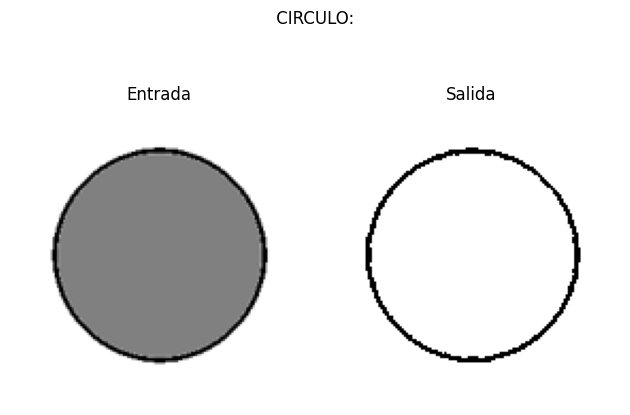

..

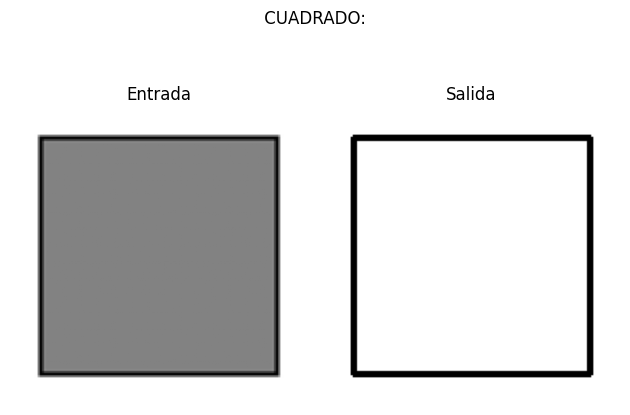

..

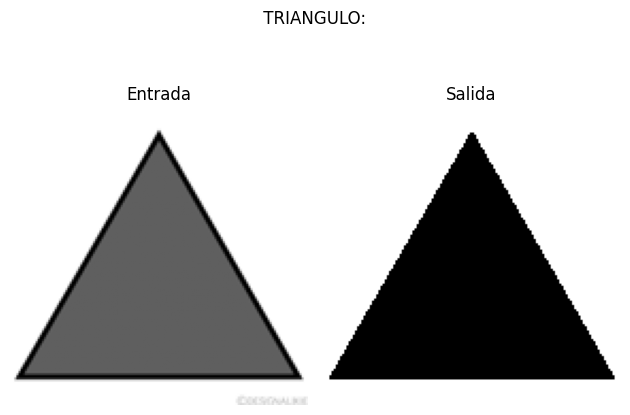

In [ ]:
#@title Probar con imágenes usadas en el entrenamiento


if len(imgsEntrenar)==0:
  print("No hay imágenes para procesar!")
else:
  # procesar imágenes de entrenamiento
  reconocerImagenes(imgsEntrenar, clasesEntrenar)


In [ ]:
#@title Probar con imágenes no usadas en el entrenamiento

if matW is None:
  print("Error: la matriz de pesos W no se encuentra definida!")
else:
  # procesar imágenes no de entrenamiento
  imgNoEntrenar, clasesNoEntrenar = determinaImgSeleccionadas(clasesEntrenar, estan=False)
  if len(imgNoEntrenar)==0:
    print("No hay imágenes no usadas para procesar!")
  else:
    # procesar imágenes no usadas en el entrenamiento
    reconocerImagenes(imgNoEntrenar, clasesNoEntrenar)


No hay imágenes no usadas para procesar!


In [ ]:
#@title Probar con imágenes que tienen ruido

cantidad_ruido = 100 #@param {type: "integer"}
solo_imagenes_entrenadas = True #@param {type: "boolean"}

# agrega ruido al azar en la imagen
def agregarRuido(imagen, cantidad=250):
    draw = ImageDraw.Draw(imagen)
    for i in range(cantidad):
      # determina color, posicion y tamaño
      color = random.randint(0, 255)
      posX = random.randint(0, imagen.size[0])
      posY = random.randint(0, imagen.size[1])
      tam = random.randint(1, imagen.size[1]//20)
      # determina tipo de ruido
      tipo = random.randint(1, 3)
      # agrega
      if tipo == 1:
        draw.point((posX, posY, posX, posY), fill=color)
      elif tipo == 2:
        draw.ellipse((posX, posY, posX + tam, posY + tam), fill=color)
      elif tipo == 3:
        draw.line((posX, posY, posX + tam, posY + tam), fill=color)
    return imagen

if matW is None:
  print("Error: la matriz de pesos W no se encuentra definida!")
else:
  if len(imgsEntrenar)==0:
    print("No hay imágenes para procesar!")
  else:
    # agrega ruido en las imagenes
    imgsRuido = []
    if solo_imagenes_entrenadas:
      # solo imágenes entrenadas
      clasesRuido = clasesEntrenar
      for im in imgsEntrenar:
        imgsRuido.append( agregarRuido( copy.deepcopy(im), cantidad_ruido ) )
    else:
      # todas las imágenes
      clasesRuido = clases_original
      for im in images_original:
        imgsRuido.append( agregarRuido( copy.deepcopy(im), cantidad_ruido ) )
    # procesar imágenes de entrenamiento
    reconocerImagenes(imgsRuido, clasesRuido)


> Cargando imágenes...

> Reconociendo imágenes: 
..

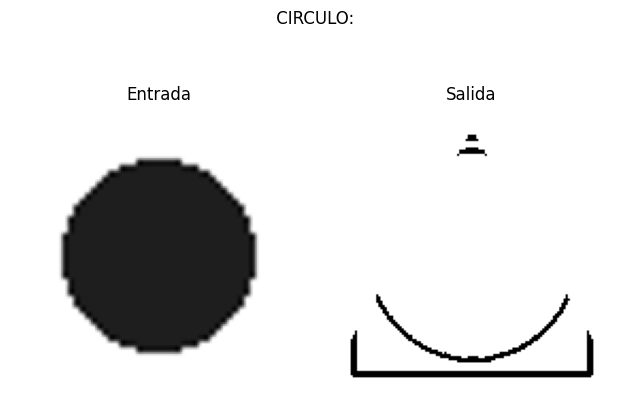

..

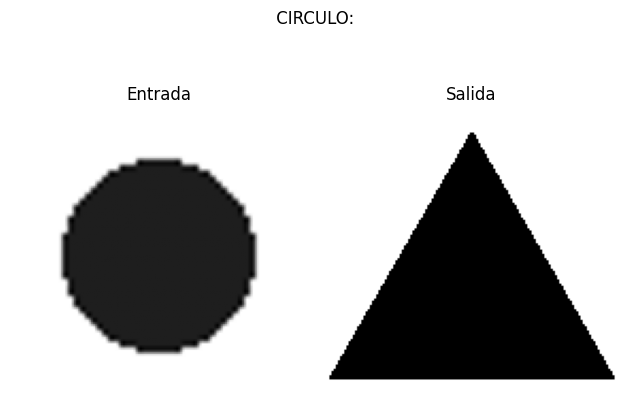

..

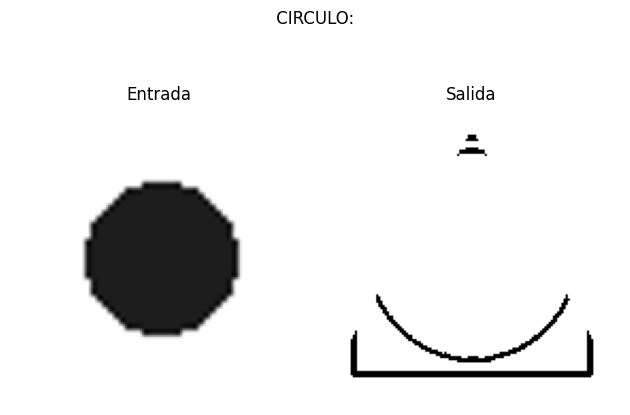

..

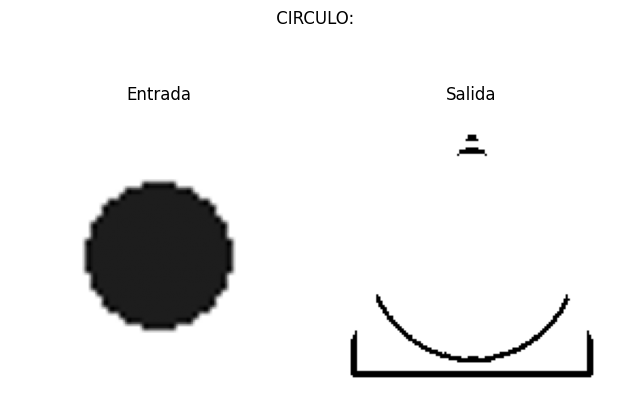

..

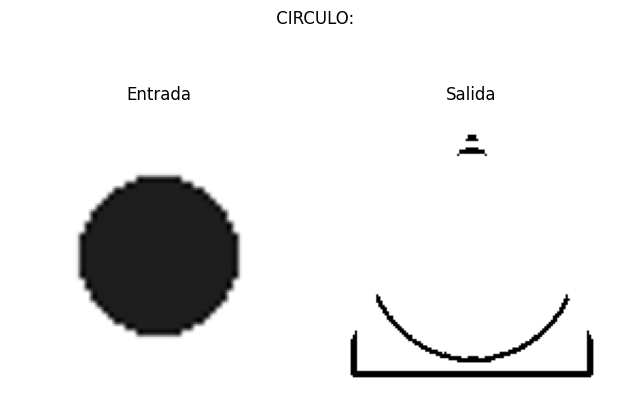

..

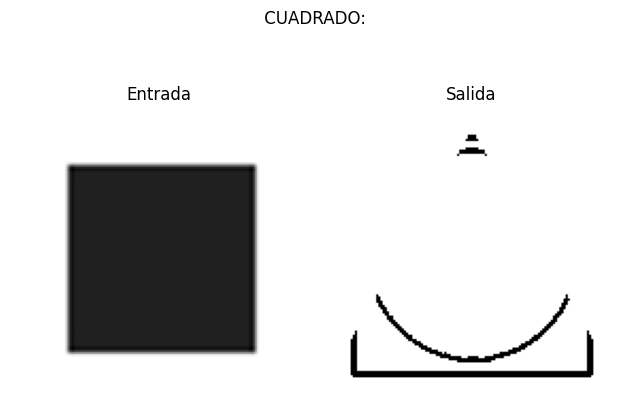

..

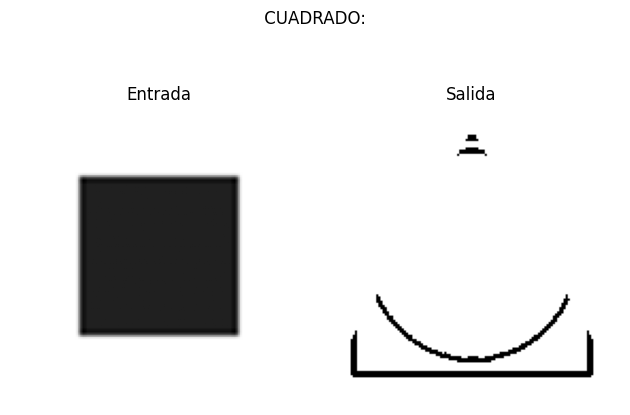

..

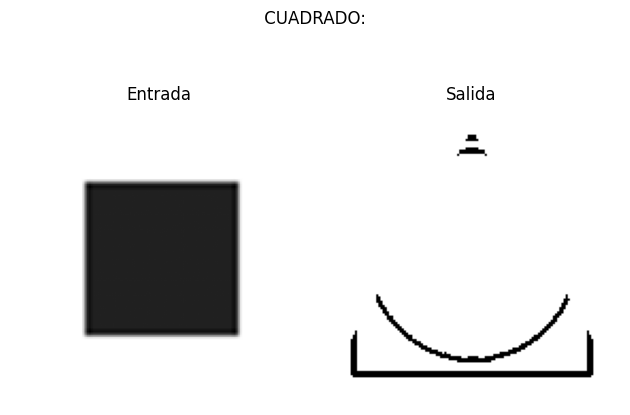

..

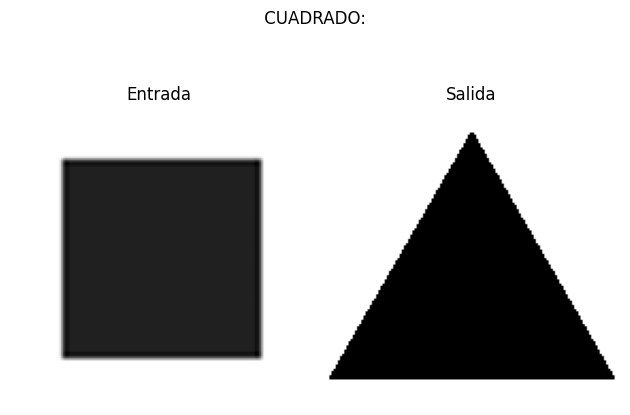

..

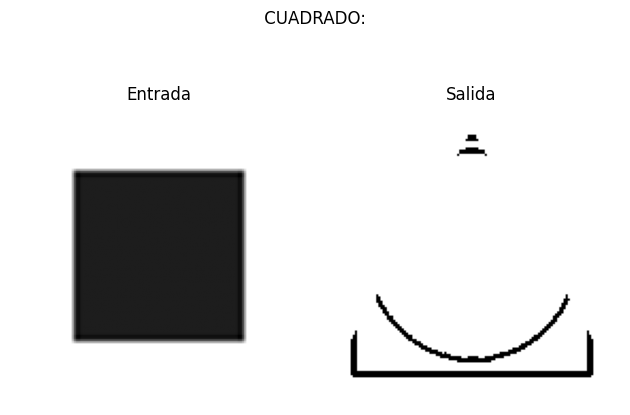

..

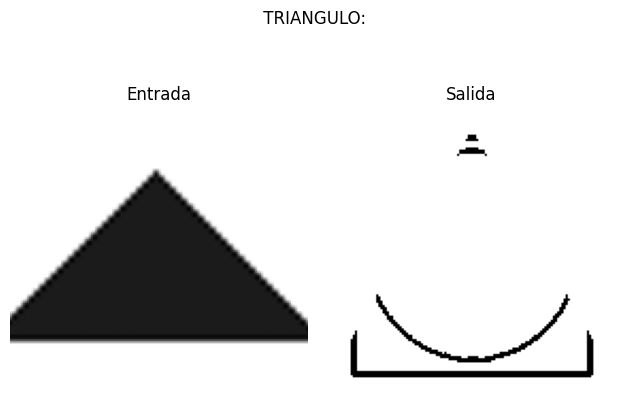

..

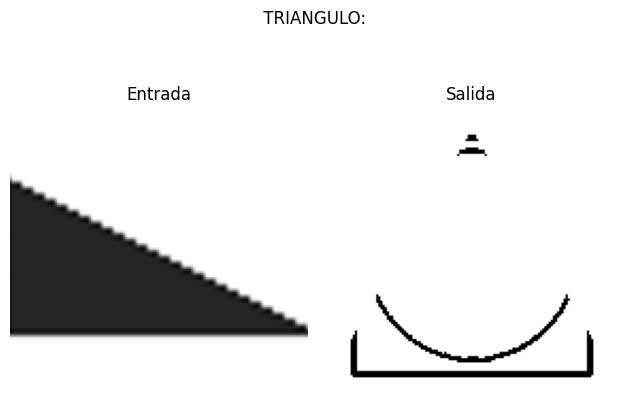

..

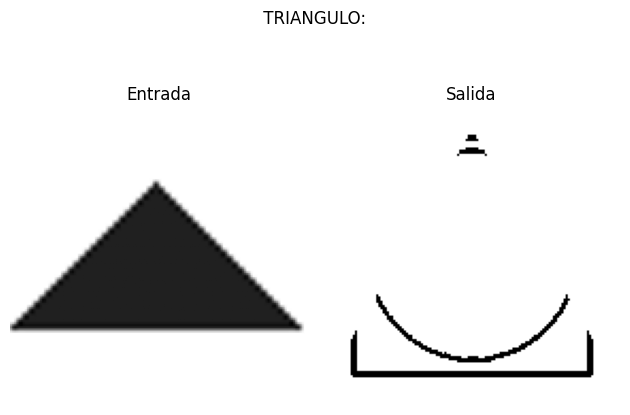

..

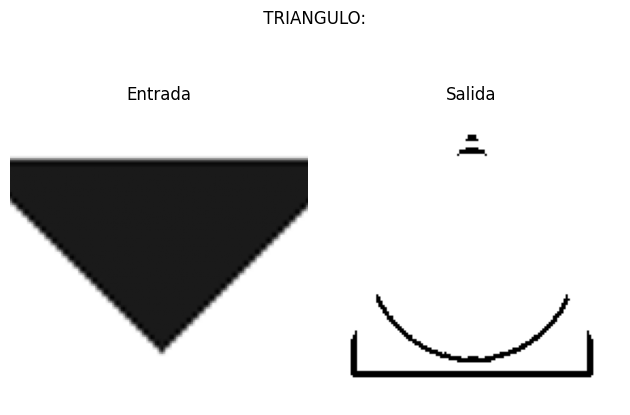

..

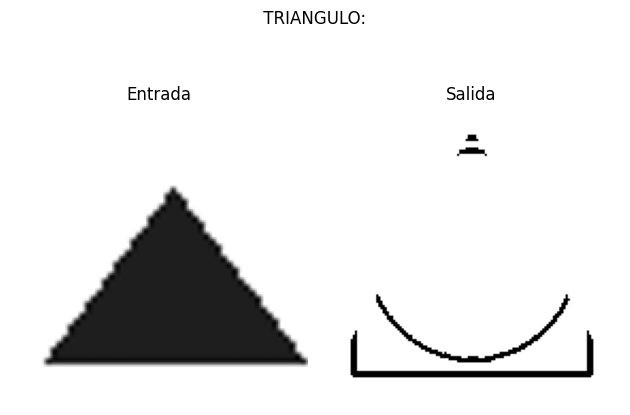

In [ ]:
#@title Probar con otras imágenes

# directorio local en Google Drive
nuevo_path = '/content/gdrive/MyDrive/demosColab/demoIA/imagenes/test' #@param {type:"string"}

proc_imagenes_clase = 5 # @param {"type":"slider","min":1,"max":100,"step":1}
if proc_imagenes_clase<1:
  proc_imagenes_clase = 1

if matW is None:
  print("Error: la matriz de pesos W no se encuentra definida!")
else:
  # procesar imágenes no de entrenamiento
  print("> Cargando imágenes...")
  nuevo_imagesList, nuevo_clasesList = cargarImagenesPath(nuevo_path,
                                                          mostrarImg=False, recursive=True,
                                                          limitarCantDir = proc_imagenes_clase)
  if len(nuevo_imagesList)==0:
    print("No se encuentran imágenes para procesar!")
  else:
    # procesar imágenes de nuevo directorio
    reconocerImagenes(nuevo_imagesList, nuevo_clasesList)
